# Presentación gráfica de datos de contagios de Sars-Covid19
Vamos a preparar un programa que descarge los datos referentes a contagios CoVid del repositorio oficial del Instituto de Salud Carlos III, https://cnecovid.isciii.es, vamos a trabajar con ellos y vamos a presentarlos con dos diferentes tipos de gráficos. 

## Librerías

Comenzamos instalando el paquete estándar que solemos necesitar en trabajos de este tipo:

In [61]:
import matplotlib
#matplotlib.use('tkagg')
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
from datetime import datetime
import seaborn as sns


Configuramos $matplotlib$ de tal manera que presente por pantalla los gráficos generados:

In [62]:
%matplotlib inline

## Descarga de los datos

Preparemos un variable con el $path$ de la $url$ en la que encontramos el repositorio de información:

In [63]:
path_datos='https://cnecovid.isciii.es/covid19/resources/datos_provincias.csv'

Preparamos un $pandas$ con la información descargada:

In [64]:
df = pd.read_csv(path_datos,na_filter = False,engine='python')

Hagamos un `Exploratory Data Analysis` de los datos:

Encontramos estas columnas de datos:

In [65]:
df.columns

Index(['provincia_iso', 'fecha', 'num_casos', 'num_casos_prueba_pcr',
       'num_casos_prueba_test_ac', 'num_casos_prueba_otras',
       'num_casos_prueba_desconocida'],
      dtype='object')

Y los primeras líneas, y últimas líneas de datos...

In [66]:
set(df.provincia_iso)

{'A',
 'AB',
 'AL',
 'AV',
 'B',
 'BA',
 'BI',
 'BU',
 'C',
 'CA',
 'CC',
 'CE',
 'CO',
 'CR',
 'CS',
 'CU',
 'GC',
 'GI',
 'GR',
 'GU',
 'H',
 'HU',
 'J',
 'L',
 'LE',
 'LO',
 'LU',
 'M',
 'MA',
 'ME',
 'MU',
 'NA',
 'O',
 'OR',
 'P',
 'PM',
 'PO',
 'S',
 'SA',
 'SE',
 'SG',
 'SO',
 'SS',
 'T',
 'TE',
 'TF',
 'TO',
 'V',
 'VA',
 'VI',
 'Z',
 'ZA'}

In [67]:
df.shape

(11076, 7)

In [68]:
df.iloc[8507]

provincia_iso                           NA
fecha                           2020-07-12
num_casos                               23
num_casos_prueba_pcr                    23
num_casos_prueba_test_ac                 0
num_casos_prueba_otras                   0
num_casos_prueba_desconocida             0
Name: 8507, dtype: object

In [69]:
df.tail()

,provincia_iso,fecha,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_otras,num_casos_prueba_desconocida
11071,V,2020-08-30,121,121,0,0,0
11072,VA,2020-08-30,35,35,0,0,0
11073,VI,2020-08-30,58,58,0,0,0
11074,Z,2020-08-30,103,4,0,0,99
11075,ZA,2020-08-30,2,2,0,0,0


Vemos que nos indica una primera clave correspondiente a la comunidad sobre la que nos da el dato (es un código iso que podemos encontrar en una búsqueda fácil de internet), el número de casos, `num_casos` que podemos ver que es equivalente a la suma de los valores del resto de columnas numéricas. Estas representan las distintas pruebas de origen del positivo: `pcr`, `test_ac`, `otras` ó `desconocidas`. Adicionalmente tenemos una columna con la fecha del día correspondiente a los datos en formato `%Y-%m-%d`

## Tratatmiento de los datos descargados

Para poder trabajar mejor con el nombre de las Comunidades vamos a generar un diccionario que contenga el nombre completo y la población (obtenida de https://es.wikipedia.org/wiki/Anexo:Provincias_y_ciudades_autónomas_de_España):

In [70]:
provincias={
 'A':['Alicante',1858683],
 'AB':['Albacete',388167],
 'AL':['Almeria',716820],
 'AV':['Avila',157640],
 'B':['Barcelona',5664579],
 'BA':['Badajoz',673559],
 'BI':['Vizcaya',1152651],
 'BU':['Burgos',356958],
 'C':['La Coruña',1123990],
 'CA':['Cadiz',1240155],
 'CC':['Cáceres',394151],
 'CE':['Ceuta',86487],
 'CO':['Cordoba',782979],
 'CR':['Ciudad Real',495761],
 'CS':['Castellón',579962],
 'CU':['Cuenca',196329],
 'GC':['Gran Canaria',1120596],
 'GI':['Gerona',771044],
 'GR':['Granada',914678],
 'GU':['Guadalajara',257762],
 'H':['Huelva',521870],
 'HU':['Huesca',220461],
 'J':['Jaén',633564],
 'L':['Lérida',434930],
 'LE':['Leon',460001],
 'LO':['Logroño',316798],
 'LU':['Lugo',329587],
 'M':['Madrid',6693394],
 'MA':['Malaga',1661785],
 'ME':['Melilla',84477],
 'MU':['Murcia',1493898],
 'O':['Oviedo',1022800],
 'OR':['Orense',307651],
 'NA':['Pamplona',654214],
 'P':['Palencia',160980],
 'PM':['Palma Mallorca',1149460],
 'PO':['Pontevedra',942665],
 'S':['Santander',581078],
 'SA':['Salamanca',330119],
 'SE':['Sevilla',1939887],
 'SG':['Segovia',153129],
 'SO':['Soria',88636],
 'SS':['Guipuzcoa',723576],
 'T':['Tarragona',804664],
 'TE':['Teruel',134137],
 'TF':['Tenerife',1032983],
 'TO':['Toledo',694844],
 'V':['Valencia',2565124],
 'VA':['Valladolid',519546],
 'VI':['Alava',331549],
 'Z':['Zaragoza',964693],
 'ZA':['Zamora',172539],
 }

In [71]:
provincias.keys() == set(df['provincia_iso'])

True

Por si acaso lo necesitamos para algun cálculo vamos a calcular la población total de España sumando las poblaciones de las Comunidades:

In [72]:
pob_spain=0
for com in provincias:
    pob_spain+=provincias[com][1]

In [73]:
pob_spain

47057990

Nos aseguramos de que el campo fecha tiene el tipo correcto, y a continuación ordenamos los datos por fecha:

In [74]:
df['fecha']=pd.to_datetime(df['fecha'],format='%Y-%m-%d')
df.sort_values(['fecha'],inplace=True)

Vamos a crear un `multiindex`con la fecha y el código de la comunidad:

In [75]:
df.set_index(['fecha','provincia_iso'],inplace=True)
df.fillna(0)

num_casos  num_casos_prueba_pcr  \
fecha      provincia_iso                                    
2020-01-31 A                      0                     0   
           MA                     0                     0   
           ME                     0                     0   
           MU                     0                     0   
           NA                     0                     0   
...                             ...                   ...   
2020-08-30 H                      9                     9   
           HU                    23                     0   
           J                     34                    34   
           LE                    64                    64   
           ZA                     2                     2   

                          num_casos_prueba_test_ac  num_casos_prueba_otras  \
fecha      provincia_iso                                                     
2020-01-31 A                                     0                       0   
           MA                                    0                       0   
           ME                                    0                       0   
           MU                                    0                       0   
           NA                                    0                       0   
...                                            ...                     ...   
2020-08-30 H                                     0                       0   
           HU                                    0                       0   
           J                                     0                       0   
           LE                                    0                       0   
           ZA                                    0                       0   

                          num_casos_prueba_desconocida  
fecha      provincia_iso                                
2020-01-31 A                                         0  
           MA                                        0  
           ME                                        0  
           MU                                        0  
           NA                                        0  
...                                                ...  
2020-08-30 H                                         0  
           HU                                       23  
           J                                         0  
           LE                                        0  
           ZA                                        0  

[11076 rows x 5 columns]

Crearemos ahora un `pandas`resumen con los resultados totales y relativo al número de habitantes:

In [76]:
resumen_por_dias=df.pivot_table(index=['fecha'],values=['num_casos'],aggfunc=np.sum)

In [77]:
resumen_por_dias['casos_habitantes']=resumen_por_dias['num_casos']/pob_spain*1000000

In [78]:
resumen_por_dias

,num_casos,casos_habitantes
fecha,,
2020-01-31,10,0.212504
2020-02-01,21,0.446258
2020-02-02,14,0.297505
2020-02-03,19,0.403757
2020-02-04,13,0.276255
...,...,...
2020-08-26,8439,179.331926
2020-08-27,7549,160.419091
2020-08-28,8046,170.980528


Podemos comprobar esa información preparando un primer gráfico de comprobación:

In [79]:
resumen_por_dias['num_casos'].sum()

497065

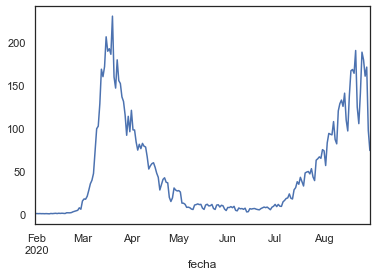

In [80]:
resumen_por_dias['casos_habitantes'].plot()

In [81]:
resultados={}
fallecidos_spain = 0
for com in provincias:
    df_aux = df.xs(com,level=1,drop_level=True).copy()
    df_aux.loc[:, 'Casos_habitantes'] = df_aux['num_casos']/provincias[com][1]*1000000
    #df_aux['Casos_habitantes']=df_aux['num_casos']/comunidades[com][1]*1000000
    resultados[com] = df_aux.copy()


Con este último código hemos conseguido construir un diccionario `resultados`en el que el `index`es el código ISO de la Comunidad, y el contenido es un `pandas`con los resultados por día. Como ejemplo vemos a continuación el pandas de Cataluña:

In [82]:
resultados['NA']

,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_otras,num_casos_prueba_desconocida,Casos_habitantes
fecha,,,,,,
2020-01-31,0,0,0,0,0,0.000000
2020-02-01,0,0,0,0,0,0.000000
2020-02-02,0,0,0,0,0,0.000000
2020-02-03,0,0,0,0,0,0.000000
2020-02-04,1,0,1,0,0,1.528552
...,...,...,...,...,...,...
2020-08-26,275,275,0,0,0,420.351750
2020-08-27,128,128,0,0,0,195.654633
2020-08-28,129,129,0,0,0,197.183185


Que de manera fácil se puede presentar en un gráfico:

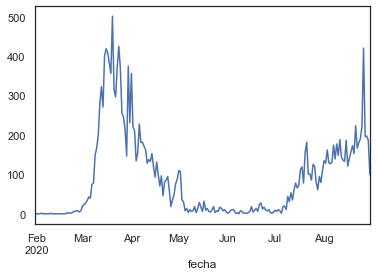

In [83]:
resultados['NA']['Casos_habitantes'].plot()

El índice es la fecha, con lo cual fácilmente se pueden filtrar los datos para un rango de fechas determinado. Por ejemplo: preparemos un gráfico con los datos desde 1 de Junio:

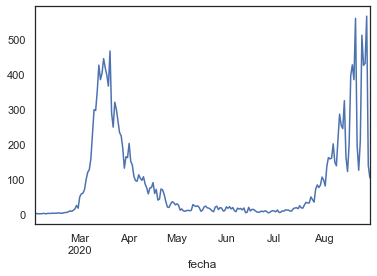

In [84]:
ref_date=datetime(year=2020,month=2,day=1)
resultados['M'][resultados['SO'].index>ref_date]['Casos_habitantes'].plot()

In [85]:
resumen_por_dias.reset_index()

,fecha,num_casos,casos_habitantes
0,2020-01-31,10,0.212504
1,2020-02-01,21,0.446258
2,2020-02-02,14,0.297505
3,2020-02-03,19,0.403757
4,2020-02-04,13,0.276255
...,...,...,...
208,2020-08-26,8439,179.331926
209,2020-08-27,7549,160.419091
210,2020-08-28,8046,170.980528
211,2020-08-29,4571,97.135471


## Gráficos

Preparemos un primer modelo. Dashboard con un gráfico de barras con los números de casos en absoluto y en relativo por cada Comunidad. Veremos una sola serie de barras pero dos ejes `y`con las dos escalas: valores en absoluto y valores por millón.

In [86]:
# Opción gráficos con barras
def barras(datos,desde_fecha):
'''
barras: genera una imagen con gráficos por comunidades con los vatos casos en absoluto
    y casos por millóm
variables:
    datos: diccionario con los pandas por comunidad
    desde_fecha: datetime con la fecha desde la que se quiere presentar los datos
'''    
    # cuatro funciones para formatear la presentación de los valores en el eje x e y
    def format_x(value, tick_number):
        return  value

    def format_x_fecha(value, tick_number):
        return resultados_filtrados['fecha'][int(value)].strftime('%-d-%b')
    
    def format_y(value, tick_number):
        return  '{:.0}'.format(value)

    def format_y_2(value, tick_number):
        return  '{}'.format(value)

    
    f = plt.figure(figsize=(12,20))
    f.subplots_adjust(hspace=.5, wspace=.5)
    #f.suptitle('Evolución positivos: '+datetime.today().strftime('%d/%m/%Y')
    f.suptitle('Evolución positivos desde: '+ref_date.strftime('%d/%m/%Y')          
           ,fontsize=30,y=0)
    color='navy'



    sns.set_style("whitegrid")
    sns.set_palette(sns.color_palette("RdBu_r",19))

    axe=f.add_subplot(7,3,1)
    resultados_filtrados=resumen_por_dias[resumen_por_dias.index>ref_date].reset_index()
        #t=resultados[comunidad].index
        #data1=resultados[comunidad]['num_casos']
    t=resultados_filtrados.index
    data1=resultados_filtrados['num_casos']
    data2=resultados_filtrados['casos_habitantes']
    axe.grid(False)
    axe.set_title('Total España',size=20)
    #sns.lineplot(t, data1, ax=axe,color='blue',linewidth=2)
    sns.barplot(x='fecha',y='num_casos',data=resultados_filtrados,ax=axe,color=color)
    axe.get_xaxis().set_ticks(t[::7])
    axe.tick_params(axis='y', labelcolor=color)
    axe.tick_params(axis='x',labelcolor=color,labelrotation=90)
    axe.set_xlabel('')

    ax2 = axe.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.grid(False)
    sns.barplot(x='fecha',y='casos_habitantes',data=resultados_filtrados,ax=ax2,color=color)

    ax2.set_ylabel('', color=sns.color_palette('RdBu_r',7)[0])
    ax2.get_xaxis().set_visible(True)   
    
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(format_x_fecha))
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(format_y_2))
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.tick_params(axis='x',labelrotation=90)
    axe.get_xaxis().set_ticks(t[::7])
    
    axe.set_ylabel('Nº de casos', color=color,size=15)

    ax2.tick_params(axis='x',labelrotation=90)
    ax2.set_xlabel('')
    
    for i,comunidad in enumerate(comunidades):
        axe=f.add_subplot(7,3,i+2)
        #resultados_filtrados=resultados[comunidad][resultados[comunidad].index>ref_date]
        resultados_filtrados=resultados[comunidad][resultados[comunidad].index>ref_date].reset_index()
        t=resultados_filtrados['fecha']
        data1=resultados_filtrados['num_casos']
        data2=resultados_filtrados['Casos_habitantes']
        axe.grid(False)
        axe.set_title(comunidades[comunidad][0],size=20)
        sns.barplot(x='fecha',y='num_casos',data=resultados_filtrados,ax=axe,color=color)
    #sns.lineplot(t, data1, ax=axe,color='blue',linewidth=2)
        axe.tick_params(axis='y', labelcolor=color)
        if (i+1) % 3 == 0 :
            axe.set_ylabel('Nº de casos', color=color,size=15)
        else:
            axe.set_ylabel('', color=color,size=15)
        axe.set_xlabel('')
        axe.tick_params(axis='x',color=color, labelrotation=90)
    
        ax2 = axe.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.grid(False)
        sns.barplot(x='fecha',y='Casos_habitantes',data=resultados_filtrados,ax=ax2,color=color)
        ax2.set_ylabel('', color=sns.color_palette('RdBu_r',7)[0])
        ax2.get_xaxis().set_visible(True)   
    #ax2.get_xaxis().set_ticks(t[::7])
        if (i) % 3 == 1 :
            ax2.set_ylabel('casos por millón hab', color=color,size=15)
        else:
            ax2.set_ylabel('')
        ax2.set_xlabel('')
        start, end = ax2.get_xlim()
        ax2.xaxis.set_ticks(np.arange(0, end, 7))
    
        ax2.xaxis.set_major_formatter(plt.FuncFormatter(format_x_fecha))
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.tick_params(axis='x',color=color,labelrotation=90)
    
    f.tight_layout()  # otherwise the right y-label is slightly clipped
    f.savefig('graficos/grafico_muertes_com.png')

IndentationError: expected an indented block (<ipython-input-86-0163e3a57838>, line 9)

ValueError: num must be 1 <= num <= 21, not 22

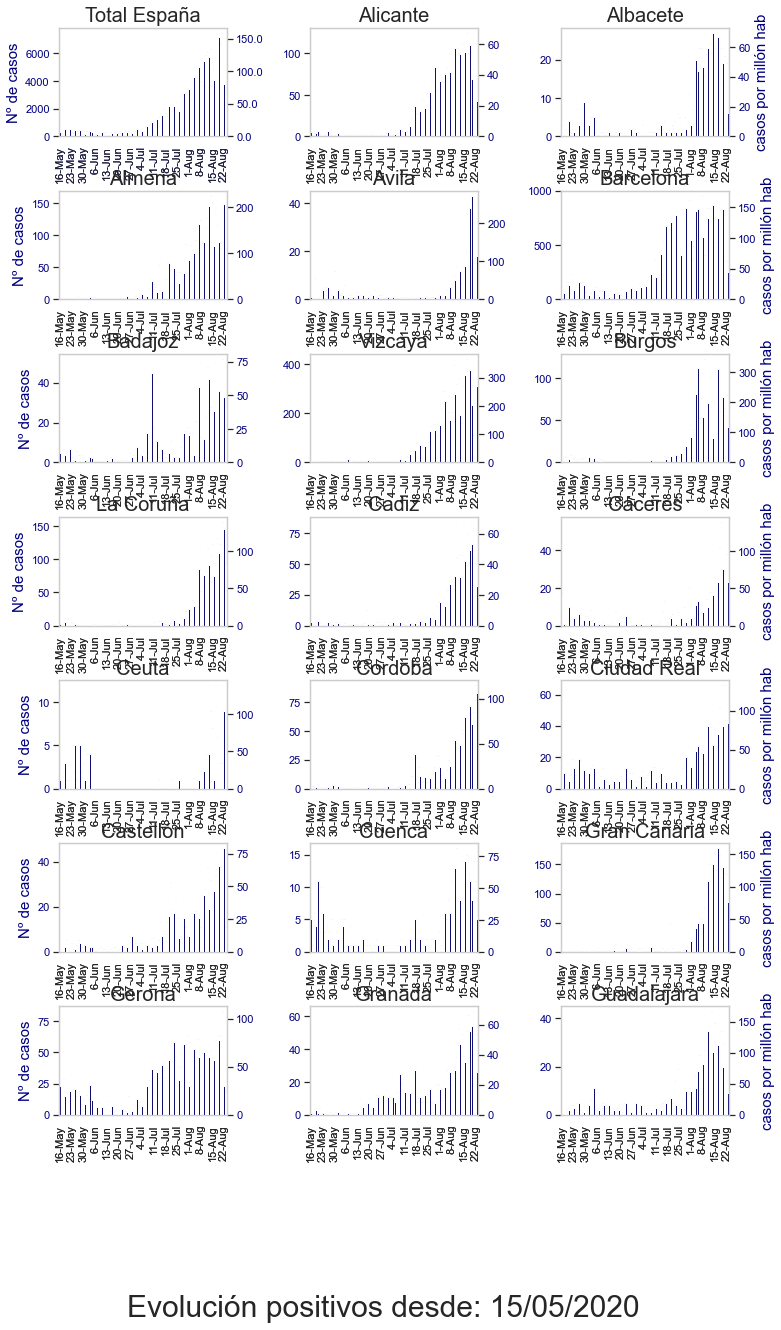

In [57]:
# Opción gráficos con barras


def format_x(value, tick_number):
        return  value

def format_x_fecha(value, tick_number):
        #print (type(value))
        #return  datetime.strftime(datetime.strptime(value[:9],'%Y-%m-%d'),'%d/%m')
        return resultados_filtrados['fecha'][int(value)].strftime('%-d-%b')
def format_y(value, tick_number):
        return  '{:.0}'.format(value)

def format_y_2(value, tick_number):
        return  '{}'.format(value)

ref_date=datetime(year=2020,month=5,day=15)    
    
f = plt.figure(figsize=(12,20))
f.subplots_adjust(hspace=.5, wspace=.5)
#f.suptitle('Evolución positivos: '+datetime.today().strftime('%d/%m/%Y')
f.suptitle('Evolución positivos desde: '+ref_date.strftime('%d/%m/%Y')          
           ,fontsize=30,y=0)
color='navy'

#plt.text(x=0, y=0,'hola', fontsize=8, alpha=0.75)

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("RdBu_r",19))

axe=f.add_subplot(7,3,1)
resultados_filtrados=resumen_por_dias[resumen_por_dias.index>ref_date].reset_index()
    #t=resultados[comunidad].index
    #data1=resultados[comunidad]['num_casos']
t=resultados_filtrados.index
data1=resultados_filtrados['num_casos']
data2=resultados_filtrados['casos_habitantes']
axe.grid(False)
axe.set_title('Total España',size=20)
#sns.lineplot(t, data1, ax=axe,color='blue',linewidth=2)
sns.barplot(x='fecha',y='num_casos',data=resultados_filtrados,ax=axe,color=color)
axe.get_xaxis().set_ticks(t[::7])

#start, end = ax.get_xlim()
#ax.xaxis.set_ticks(np.arange(start, end, 0.712123))
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

#axe.xaxis.set_ticks(t[::3])
axe.tick_params(axis='y', labelcolor=color)
axe.tick_params(axis='x',labelcolor=color,labelrotation=90)
axe.set_xlabel('')

ax2 = axe.twinx()  # instantiate a second axes that shares the same x-axis
ax2.grid(False)
#ax2.set_ylabel('', color=color)  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color,label='casos habitantes')
#ax2.plot(t,data3,color='black',label='Activos')
sns.barplot(x='fecha',y='casos_habitantes',data=resultados_filtrados,ax=ax2,color=color)
  
#sns.lineplot(t, data2, label='Casos',ax=ax2,color=sns.color_palette('RdBu_r',7)[0],linewidth=5)
#sns.lineplot(t,data3,label='Muertes',ax=ax2,color='blue',linewidth=5)
    
#ax2.tick_params(axis='y', labelcolor=color)

ax2.set_ylabel('', color=sns.color_palette('RdBu_r',7)[0])
ax2.get_xaxis().set_visible(True)   
    
ax2.xaxis.set_major_formatter(plt.FuncFormatter(format_x_fecha))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(format_y_2))
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='x',labelrotation=90)
axe.get_xaxis().set_ticks(t[::7])
#ax2.legend()
#ax2.set_yscale('log')
    
axe.set_ylabel('Nº de casos', color=color,size=15)

#axe.xaxis.set_major_formatter(plt.FuncFormatter(format_x))
    #axe.yaxis.set_major_formatter(plt.FuncFormatter(format_y))    
    #axe.get_xaxis().set_ticks([])
    #axe.get_xaxis().set_visible(False)
ax2.tick_params(axis='x',labelrotation=90)
ax2.set_xlabel('')
    #axe.legend()
    #ax2.set_yscale('log')    

for i,provincia in enumerate(provincias):
    axe=f.add_subplot(7,3,i+2)
    #resultados_filtrados=resultados[comunidad][resultados[comunidad].index>ref_date]
    resultados_filtrados=resultados[provincia][resultados[provincia].index>ref_date].reset_index()
    #t=resultados[comunidad].index
    #data1=resultados[comunidad]['num_casos']
    t=resultados_filtrados['fecha']
    data1=resultados_filtrados['num_casos']
    data2=resultados_filtrados['Casos_habitantes']
    axe.grid(False)
    axe.set_title(provincias[provincia][0],size=20)
    sns.barplot(x='fecha',y='num_casos',data=resultados_filtrados,ax=axe,color=color)
    #sns.lineplot(t, data1, ax=axe,color='blue',linewidth=2)
    axe.tick_params(axis='y', labelcolor=color)
    if (i+1) % 3 == 0 :
        axe.set_ylabel('Nº de casos', color=color,size=15)
    else:
        axe.set_ylabel('', color=color,size=15)
    axe.set_xlabel('')
    #axe.xaxis.set_major_formatter(plt.FuncFormatter(format_x))
    #axe.yaxis.set_major_formatter(plt.FuncFormatter(format_y))    
    #axe.get_xaxis().set_ticks([])
    #axe.get_xaxis().set_visible(False)
    axe.tick_params(axis='x',color=color, labelrotation=90)
    #axe.legend()
    #ax2.set_yscale('log')
    ax2 = axe.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.grid(False)
    #ax2.set_ylabel('', color=color)  # we already handled the x-label with ax1
    #ax2.plot(t, data2, color=color,label='Confirmados')
    sns.barplot(x='fecha',y='Casos_habitantes',data=resultados_filtrados,ax=ax2,color=color)
    #ax2.plot(t,data3,color='black',label='Activos')
    
    #sns.lineplot(t, data2, label='Casos',ax=ax2,color=sns.color_palette('RdBu_r',7)[0],linewidth=5)
    #sns.lineplot(t,data3,label='Muertes',ax=ax2,color='blue',linewidth=5)
    
    #ax2.tick_params(axis='y', labelcolor=color)

    ax2.set_ylabel('', color=sns.color_palette('RdBu_r',7)[0])
    ax2.get_xaxis().set_visible(True)   
    #ax2.get_xaxis().set_ticks(t[::7])
    if (i) % 3 == 1 :
        ax2.set_ylabel('casos por millón hab', color=color,size=15)
    else:
        ax2.set_ylabel('')
    ax2.set_xlabel('')
    start, end = ax2.get_xlim()
    #start=list(resultados_filtrados['fecha'])[0]
    #end=list(resultados_filtrados['fecha'])[-1]
    ax2.xaxis.set_ticks(np.arange(0, end, 7))
    #ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    #ax2.get_xaxis().set_ticks(resultados_filtrados['fecha'][::7].values)
    
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(format_x_fecha))
    #ax2.yaxis.set_major_formatter(plt.FuncFormatter(format_y_2))
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.tick_params(axis='x',color=color,labelrotation=90)
    #ax2.legend()
    #ax2.set_yscale('log')
    


f.tight_layout()  # otherwise the right y-label is slightly clipped
#f.savefig('graficos/grafico_muertes_com.png')

In [58]:
def format_x(value, tick_number):
        return  datetime.fromordinal(int(value)).strftime('%d-%b')


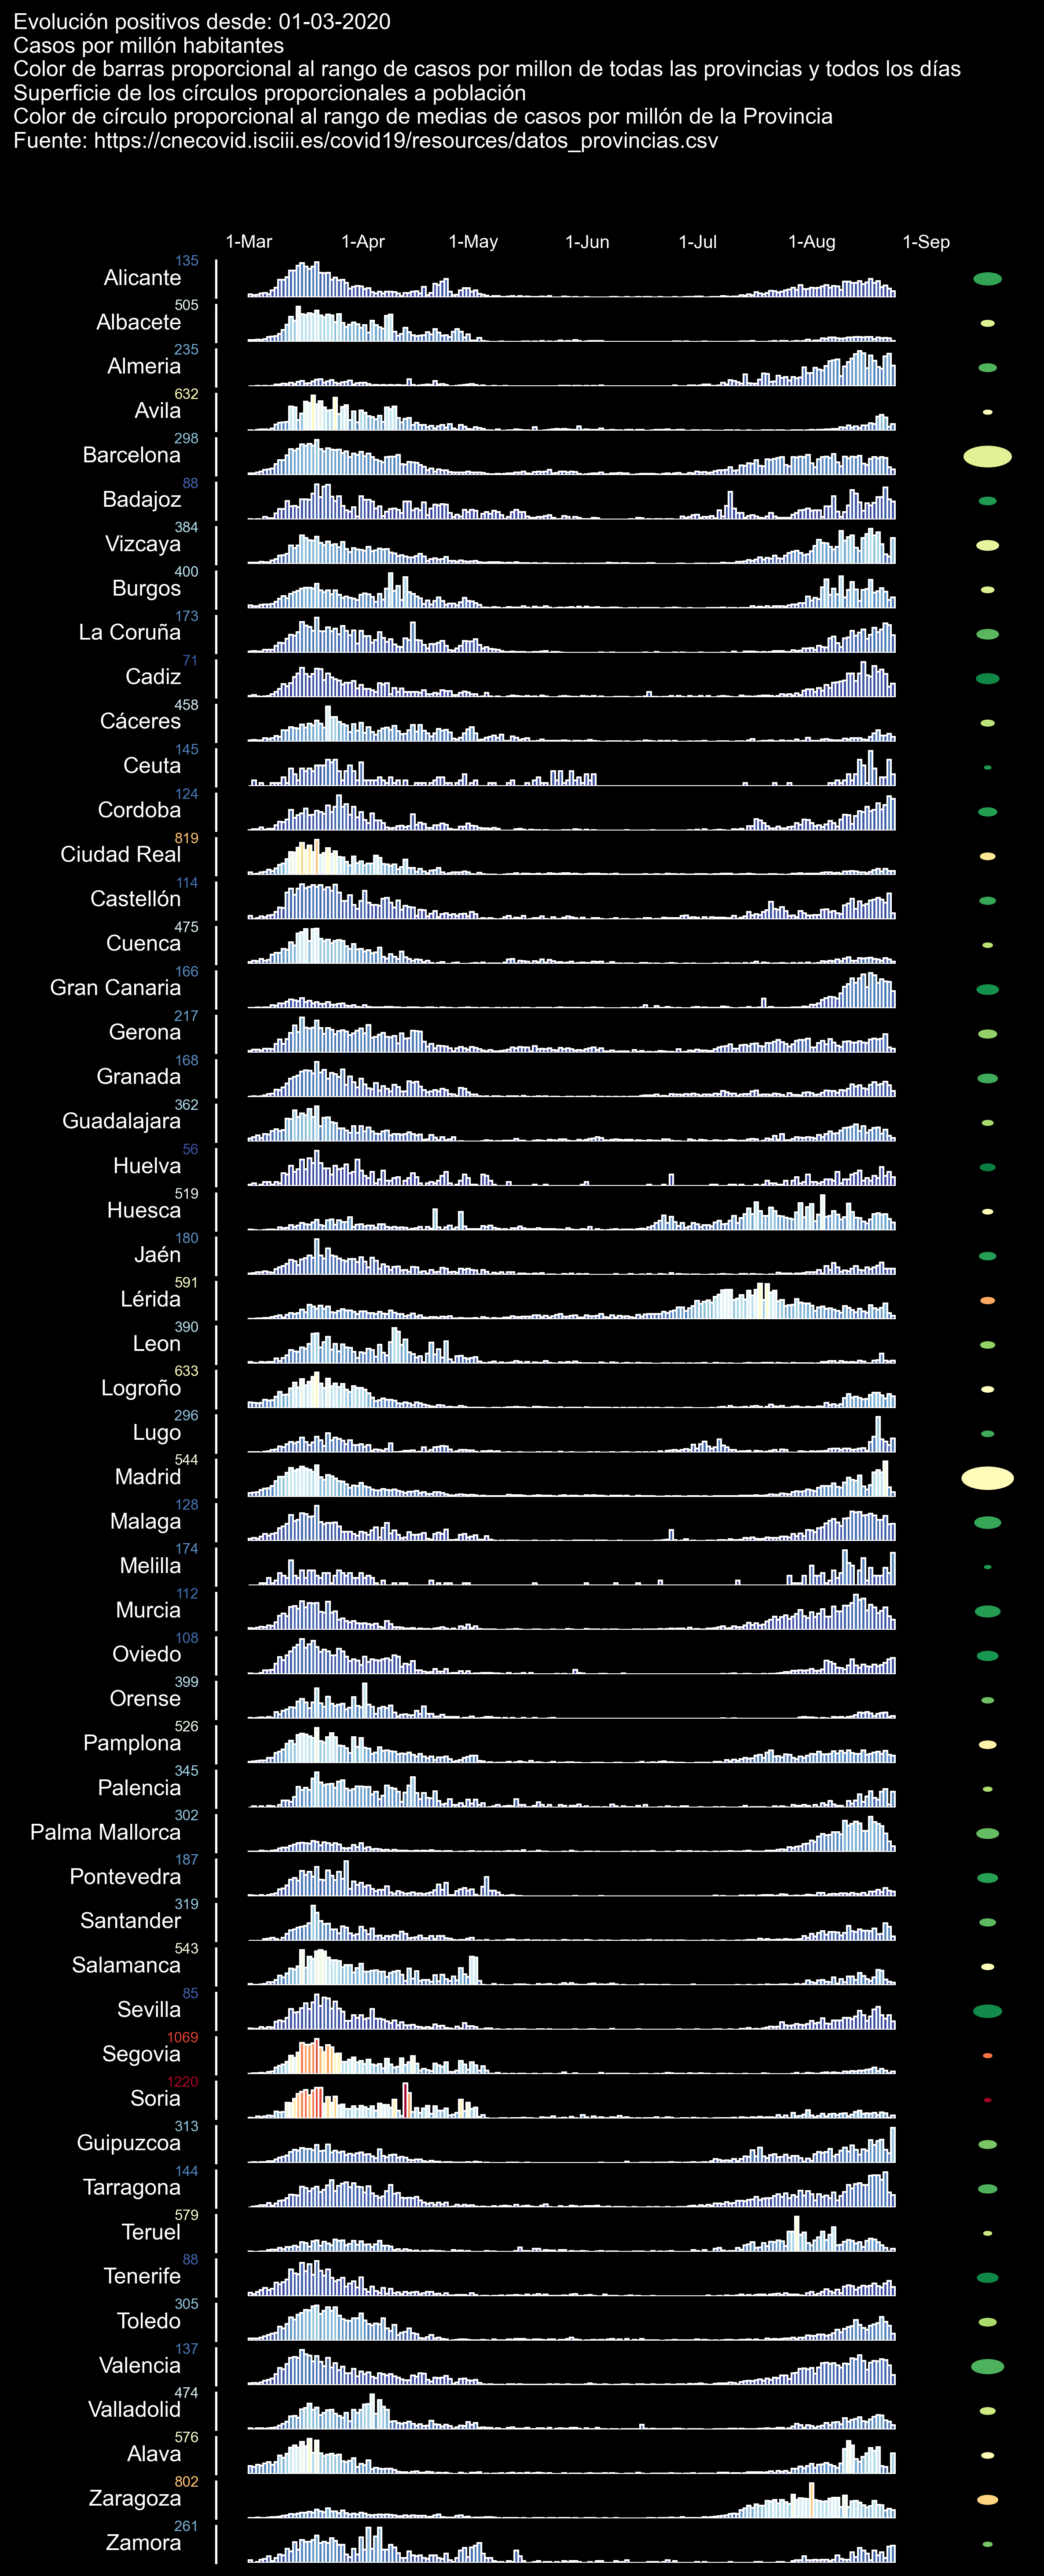

In [59]:
# Set canvas background color the same as axes
#mean_ratio=0.001
plt.rc('figure', facecolor='black')
plt.style.use('dark_background')
plt.ion()

# set constrianed_layout as True to avoid axes overlap
#fig = plt.figure(figsize=(10,20 ), dpi=300, constrained_layout=True)
fig = plt.figure(figsize=(10,24),dpi=300)
desde_fecha=datetime(year=2020,month=3,day=1)
titulo='''Evolución positivos desde: {} \nCasos por millón habitantes
Color de barras proporcional al rango de casos por millon de todas las provincias y todos los días
Superficie de los círculos proporcionales a población
Color de círculo proporcional al rango de medias de casos por millón de la Provincia
Fuente: https://cnecovid.isciii.es/covid19/resources/datos_provincias.csv'''
fig.suptitle(titulo.format(desde_fecha.strftime('%d-%m-%Y'))        
           ,fontsize=12,x=.05,y=.93,ha='left')
  
# Use GridSpec for customising layout
gs = fig.add_gridspec(nrows=54, ncols=10)



ax=fig.add_subplot(gs[1,1:8])
ax.bar(resultados['M'][resultados['M'].index >= desde_fecha].index,0,color='xkcd:black',
       edgecolor='black',width=0.5,align='edge')
ax.set_facecolor('xkcd:black')
ax.spines['bottom'].set_visible(False)  
ax.spines['right'].set_visible(False)  
ax.spines['left'].set_visible(False)  
ax.spines['top'].set_visible(False)

ax.grid(False,which='both')
#ax.tick_params(axis='x',direction='out',labelrotation=90)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_x))

ax.axes.get_yaxis().set_visible(False)
#ax.axes.get_xaxis().set_visible(False)
#ax.get_xaxis().set_ticks(resultados['M'][resultados['M'].index >= desde_fecha].index[::20])
ax.tick_params(axis='x',size=0,labelsize=10,pad=-10)
#ax.get_yaxis().set_ticks([])
#ax.xaxis.set_ticks_position(position='top')

majorFmt = mdates.DateFormatter('%-d-%b')
ax.xaxis.set_major_locator(mdates.MonthLocator([1,2,3,4,5,6,7,8,9,10,11,12]))
ax.xaxis.set_major_formatter(majorFmt)
#ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_y))


ratio_max=0
average_com={}
color_average_com={}
max_average=0
for i, com in enumerate(provincias):
    df_data=resultados[com][resultados[com].index >= desde_fecha]
    average_com[com]=df_data['Casos_habitantes'].mean()
    if average_com[com] > max_average:
        max_average=average_com[com]
    if df_data['Casos_habitantes'].replace(np.inf,np.nan).max() > ratio_max:
        ratio_max=df_data['Casos_habitantes'].max()
for i, com in enumerate(provincias):
    average_com[com]/=max_average
    color_average_com[com]=cm.RdYlGn_r(average_com[com])


for i, com in enumerate(provincias):
    #nombre provincias
    ax1 = fig.add_subplot(gs[i+2,0])
    ax1.set_facecolor('xkcd:black')
    ax1.annotate('{}'.format(provincias[com][0]), (0.8, 0.5), size=12,xycoords='axes fraction', va='center', ha='right')
    ax1.spines['bottom'].set_visible(False)  
    ax1.spines['right'].set_visible(False)  
    ax1.spines['left'].set_visible(False)  
    ax1.spines['top'].set_visible(False)
    ax1.get_xaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])
    
    #ax = fig.add_subplot(19,1,i+1, ylim=(-.0001, 0.0001))
    ax = fig.add_subplot(gs[i+2, 1:8])
    
    ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    
    df_data=resultados[com][resultados[com].index > desde_fecha]
    mean_ratio=df_data['num_casos'].mean()
    # color scheme
    # colors = cm.RdYlBu_r(resultados[com]['Fallecidos_por_hab'] / resultados[com]['Fallecidos_por_hab'].max())
    # ax.bar(resultados[com].index, df_data['Fallecidos_por_hab'] - mean_ratio, label='_1',color=colors,
    #       width=0.7, align="edge")
    
    #colors = cm.RdYlBu_r(df_data['Casos_habitantes'] / df_data['Casos_habitantes'].replace(np.inf,np.nan).max())
    colors = cm.RdYlBu_r(df_data['Casos_habitantes'] / ratio_max)
    
    ax.bar(df_data.index, df_data['Casos_habitantes'], label='_1',color=colors,
           width=1, align="edge")
    
    
    #Calculemos el color de valor maximo, para que indique el rango del valor
    color_max = colors[np.argmax(df_data['Casos_habitantes'])]
    start, end = ax.get_ylim()
    ax.get_yaxis().set_ticks([int(end)])
    
    #ax.yaxis.label.set_color(color_max)
    ax.tick_params(axis='y',colors=color_max,labelsize=8)

    
    # customise axes
    ax.spines['bottom'].set_visible(False)  
    ax.spines['right'].set_visible(False)  
    #ax.spines['left'].set_visible(False)  
    ax.spines['top'].set_visible(False)
    ax.grid(False,which='both')
    ax.get_xaxis().set_ticks([])
    


    #ax.set_ylabel(comunidades[com][0], rotation=0, color='#e3e3e3', fontsize=10, fontweight='bold')
    
    
    
    ax2=fig.add_subplot(gs[i+2,8:9])
    circle1 = plt.Circle((0.5, 0.5), np.sqrt(provincias[com][1]/np.pi)/5000, color=color_average_com[com])
    ax2.spines['bottom'].set_visible(False)  
    ax2.spines['right'].set_visible(False)  
    ax2.spines['left'].set_visible(False)  
    ax2.spines['top'].set_visible(False)
    ax2.set_facecolor('xkcd:black')
    #ax2.set_ylabel('', rotation=0, color='black')
    #ax2.set_xlabel('', rotation=0, color='black')
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.add_artist(circle1)

#plt.tight_layout()
path='graficos/'
pref='temporal_por_provincias_hasta'
nombre_fichero=path+pref+'.png'
fig.savefig(nombre_fichero)
plt.show()

<Figure size 432x288 with 0 Axes>

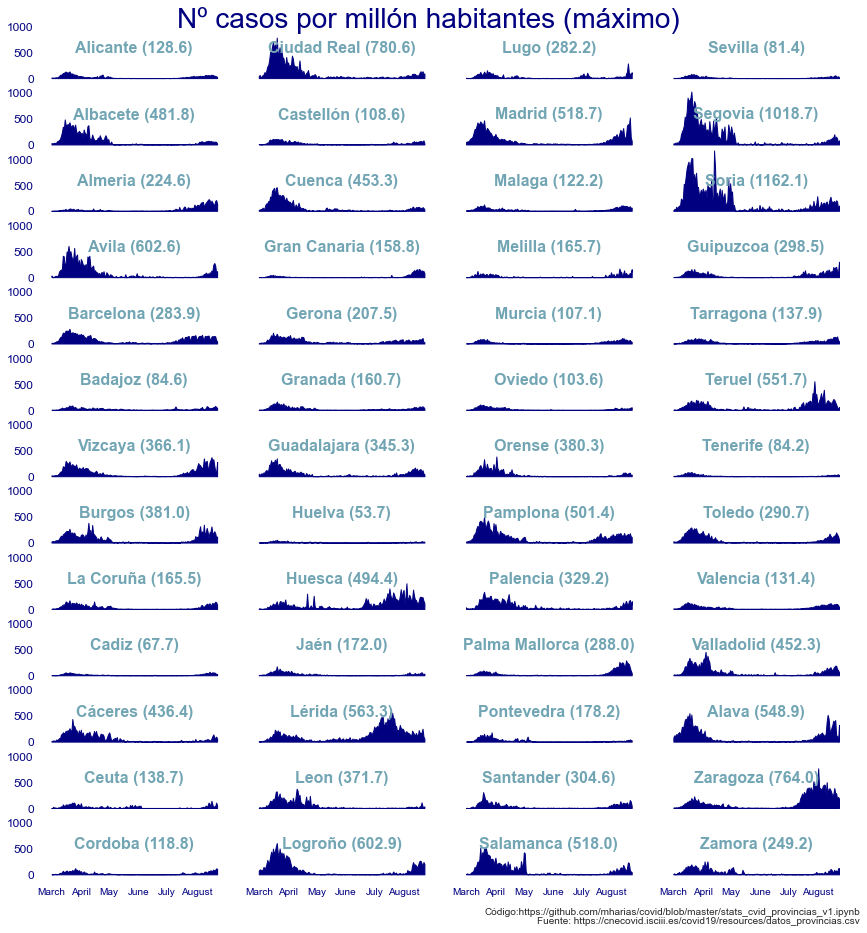

In [60]:

sns.set(style="white",rc={"axes.facecolor": (0, 0, 0, 0)})


# Preparamos los datos
datos=df.reset_index()
datos.sort_values(['provincia_iso','fecha'],inplace=True)
datos['casos_millon']=datos.apply(lambda x: x['num_casos']/provincias[x['provincia_iso']][1]*1000000,axis=1)
datos = datos[datos['fecha']>=datetime(year=2020,month=3,day=1)]

sin_ordenar = list(provincias.keys())
ordenado = [sin_ordenar[i//4+(i%4)*13] for i in range(0,len(sin_ordenar))] #lista ordenada en vertical
github_url = 'https://github.com/mharias/covid/blob/master/stats_cvid_provincias_v1.ipynb'

# Creamos la figura desde Matplotlib
plt.figure()

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(52, rot=-.25, light=.7)
g = sns.FacetGrid(datos,col='provincia_iso', hue='provincia_iso',col_wrap=4,col_order=ordenado,
                  aspect=3, height=1, palette=pal)
# Título
g.fig.suptitle('Nº casos por millón habitantes (máximo)',fontsize=28,color='navy')
g.fig.text(1, 0,'Fuente: {}'.format(path_datos), fontsize=10,horizontalalignment='right') #add text
g.fig.text(1,0.01,'Código:{}'.format(github_url),
           fontsize=10,horizontalalignment='right')
# Draw the densities in a few steps
g.map(plt.fill_between, 'fecha','casos_millon',color='navy')
#g.map(plt.axhline, y=0, lw=1, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    valor_max = datos[datos['provincia_iso']==label]['casos_millon'].max()
    ax.text(0.5, .5, '{} ({:0.1f})'.format(provincias[label][0],valor_max), fontweight="bold", color=pal[10],
            ha="center", va="center", size=16,transform=ax.transAxes)

g.map(label,'provincia_iso')


# Establecemos la distancia entre gráficos verticalmente para que no haya solapes
g.fig.subplots_adjust(hspace=0)

# Quitamos los títulos, título del eje x, y todos los ticks de y
g.set_titles("")
g.set(yticks=[])
g.set(xlabel='')

# Formateamos el gráfico: numero de xticks, formato de la etiqueta, colores...
XmajorFmt = DateFormatter('%B')

for ax in g.axes:
    ax.xaxis.set_major_formatter(XmajorFmt)
    ax.xaxis.set_tick_params(labelsize=10,labelcolor='navy')
    ax.xaxis.set_major_locator(DayLocator([1]))
    
    ax.yaxis.set_tick_params(labelsize=12,labelcolor='navy')
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
    
    
# quitamos los ejes para dar más claridad a cada gráfico
g.despine(bottom=True, left=True)

#plt.tight_layout()
plt.show()